# Dear Gentle Reader,

My name is Ron Morelli, and I've taken on the task of selecting a selection of Reddit comments from Dec. 2016, to find out if there's a correlation between up votes and the title of a post.

The grand question I have is: Does the context of a title influence people to vote that post up?  Or: What are elements in a Reddit post that make people upvote it?  

Let us explore this on our pythonic journey together . . . 

# Let's import a plethora of trinkets to make the magic work.

I never know what tools I'll need, so I tend to bring everything in just in case.

In [4]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.feature_extraction.text import CountVectorizer, \
HashingVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import linear_model, svm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from nltk.corpus import stopwords
from textblob import TextBlob
import string
import spacy

# Let's bring in the dataset.



In [5]:
df=pd.read_csv("reddit_posts.csv")

# Let's start cleaning.

In [6]:
'''This will tell me what the % is of blank features in columns.  
I'm going to drop all of these, because they're such a high percentage.  At the lowest range it's 82%.'''

blanks = df.isnull().sum()/len(df) 
blanks= blanks[blanks > 0]
blanks.sort_values(inplace=True)
blanks.sort_values(ascending=False).head(100)

third_party_tracking_2    1.000000
mobile_ad_url             1.000000
promoted_url              1.000000
original_link             1.000000
promoted_by               1.000000
promoted                  1.000000
adserver_click_url        1.000000
promoted_display_name     1.000000
third_party_tracking      1.000000
imp_pixel                 1.000000
href_url                  1.000000
disable_comments          1.000000
adserver_imp_pixel        1.000000
distinguished             0.996815
secure_media              0.989958
media                     0.989958
author_flair_text         0.986848
author_flair_css_class    0.983701
post_hint                 0.868368
preview                   0.868368
link_flair_css_class      0.839179
link_flair_text           0.827263
dtype: float64

In [7]:
#The droppening.

blanks = df.isnull().sum()/len(df) 
blanks= blanks[blanks > 0]
blanks.sort_values(inplace=True)
blanks.sort_values(ascending=False).head(100)

df = df.drop(['link_flair_text', 'link_flair_css_class',
             "preview", "post_hint", "author_flair_css_class",
             "author_flair_text", "secure_media", "media", "secure_media",
              "distinguished", "adserver_imp_pixel", "disable_comments", "href_url",
              "imp_pixel","third_party_tracking", "promoted_display_name", 
              "adserver_click_url",
              "promoted", "promoted_by", "original_link", "promoted_url", "mobile_ad_url",
              "third_party_tracking_2", "archived", 
    ], 1)


In [8]:
#Checking if they dropped or not.
df.head(3)

,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,is_self,...,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups,url
0,johnnyawesome0,False,1480697304,self.techsupport,0.0,False,0.0,False,5g49s2,True,...,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,Silverfin113,False,1480697424,self.learnprogramming,0.0,False,0.0,False,5g4a5p,True,...,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,bookbooksbooks,False,1480697613,self.gamedev,0.0,False,0.0,False,5g4att,True,...,{},"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...


In [9]:
#Checking the shape of my dataframe.
df.shape

(26688, 30)

In [10]:
#Making sure df just have up votes that are above 0.  If a subject lacks any upvotes it's gone.
df=df[df['ups'] > 0]

In [11]:
#Re-checking the shape of my dataframe.
df.shape

(22989, 30)

In [12]:
#Who are my monster up votes?
df[["ups"]].sort_values(by=["ups"],ascending=False)

,ups
21737,26573.0
3772,19530.0
4635,6300.0
11330,4792.0
11400,3927.0
7627,3478.0
23753,3458.0
3465,3319.0
11467,2258.0
11443,2082.0


In [13]:
 #Feng shui my dataframe. I want the ups and the title closer to the left so I can see.
df = pd.DataFrame(df, 
                      columns=['ups', 'title', 'author','gilded', 'over_18','contest_mode', 'created_utc', 'domain', 'downs', 'edited',
       'hide_score', 'id', 'is_self', 'locked', 'media_embed',
        'name', 'num_comments',  'permalink', 'quarantine',
        'retrieved_on', 'saved', 'score', 'secure_media_embed', 'selftext',
        'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'thumbnail',
        'url'

 ])

In [14]:
#Checking if it worked.
df.head(2)

,ups,title,author,gilded,over_18,contest_mode,created_utc,domain,downs,edited,...,saved,score,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,url
0,1.0,Help with audio set-up,johnnyawesome0,0.0,False,False,1480697304,self.techsupport,0.0,False,...,False,1.0,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,https://www.reddit.com/r/techsupport/comments/...
1,23.0,Optimizing code for speed,Silverfin113,0.0,False,False,1480697424,self.learnprogramming,0.0,False,...,False,23.0,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,https://www.reddit.com/r/learnprogramming/comm...


In [15]:
df.columns

Index(['ups', 'title', 'author', 'gilded', 'over_18', 'contest_mode',
       'created_utc', 'domain', 'downs', 'edited', 'hide_score', 'id',
       'is_self', 'locked', 'media_embed', 'name', 'num_comments', 'permalink',
       'quarantine', 'retrieved_on', 'saved', 'score', 'secure_media_embed',
       'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'thumbnail', 'url'],
      dtype='object')

In [16]:
#Checking index.
df.index

Int64Index([    0,     1,     2,     4,     5,     7,     8,     9,    10,
               11,
            ...
            26677, 26679, 26680, 26681, 26682, 26683, 26684, 26685, 26686,
            26687],
           dtype='int64', length=22989)

In [17]:
df[["score", 'ups']] #Score and Ups seem to actually match.

,score,ups
0,1.0,1.0
1,23.0,23.0
2,12.0,12.0
4,6.0,6.0
5,1.0,1.0
7,8.0,8.0
8,2.0,2.0
9,1.0,1.0
10,1.0,1.0
11,3.0,3.0


In [18]:
#Let's ditch score then.
df.drop(["score"], inplace=True, axis=1)

# I want to examine title and see if there's a correlation between words used in the title of a post and upvotes cast for that post.  To do that I'll want to do a subjectivity and a polarity score check on the title.

In [19]:
#I'll use TextBlob.
title_textblob = TextBlob(df["title"].iloc[1])#loop using iloc

print(title_textblob.sentiment.subjectivity, title_textblob.sentiment.polarity)

0.0 0.0


In [20]:
'''Breaking up my subjectivity and my polarity.  Creating a new variable called sentiment.  
Sentiment will be a dictionary.'''

sentiment={"subjectivity": [], "polarity": []}

for i in range(0, df.shape[0]):
    title_textblob = TextBlob(df["title"].iloc[i])
    sentiment["subjectivity"].append(title_textblob.sentiment.subjectivity)
    sentiment["polarity"].append(title_textblob.sentiment.polarity)

In [21]:
#Let's see if it worked.
pd.DataFrame.from_dict(sentiment)

,polarity,subjectivity
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,-0.033333,0.185714
7,0.000000,0.000000
8,0.000000,0.000000
9,0.200000,0.300000


In [22]:
'''I'm going to make sentiment into a new variable called polarity.  
I had to rename the columns, though, because when I feng shuied things the column names dropped off.'''
polarity=pd.concat([df, pd.DataFrame.from_dict(sentiment).set_index(df.index)],
                  axis=1, ignore_index=True).rename(columns={0: 'ups', 1: 'title', 16: 'num_comments',
                                                             29: "polarity", 30: "subjectivity", 3:'gilded'})

In [23]:
#Checking to see if the column re-named worked.
polarity

,ups,title,2,gilded,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,polarity,subjectivity
0,1.0,Help with audio set-up,johnnyawesome0,0.0,False,False,1480697304,self.techsupport,0.0,False,...,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,https://www.reddit.com/r/techsupport/comments/...,0.000000,0.000000
1,23.0,Optimizing code for speed,Silverfin113,0.0,False,False,1480697424,self.learnprogramming,0.0,False,...,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,https://www.reddit.com/r/learnprogramming/comm...,0.000000,0.000000
2,12.0,Seeking Tales of Development Woe (and Triumph)...,bookbooksbooks,0.0,False,False,1480697613,self.gamedev,0.0,False,...,{},"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,self,https://www.reddit.com/r/gamedev/comments/5g4a...,0.000000,0.000000
4,6.0,currying functions using functools,caffeine_potent,0.0,False,False,1480697748,self.learnpython,0.0,1480709138,...,{},I have the following representation of argumen...,False,False,learnpython,t5_2r8ot,self,https://www.reddit.com/r/learnpython/comments/...,0.000000,0.000000
5,1.0,Text Editor integration,uzbek1993,0.0,False,False,1480697775,self.learnprogramming,0.0,False,...,{},I am about to create a website where users use...,False,False,learnprogramming,t5_2r7yd,self,https://www.reddit.com/r/learnprogramming/comm...,0.000000,0.000000
7,8.0,What are some ways to learn efficient python?,excitedaboutemacs,0.0,False,False,1480697827,self.learnpython,0.0,False,...,{},This [post](https://www.reddit.com/r/learnpyth...,False,False,learnpython,t5_2r8ot,self,https://www.reddit.com/r/learnpython/comments/...,0.000000,0.000000
8,2.0,Requesting help with moving a file from local ...,Steakuddin,0.0,False,False,1480697900,self.linux,0.0,False,...,{},[removed],False,False,linux,t5_2qh1a,default,https://www.reddit.com/r/linux/comments/5g4btt...,-0.033333,0.185714
9,1.0,No screen on startup when display has freesync...,Firenzzz,0.0,False,False,1480698099,self.techsupport,0.0,False,...,{},As the title says. Yesterday I've finally had ...,False,False,techsupport,t5_2qioo,self,https://www.reddit.com/r/techsupport/comments/...,0.000000,0.000000
10,1.0,Do you life adventure? Don't forget to take th...,[deleted],0.0,False,False,1480698138,amazon.com,0.0,False,...,{},[deleted],False,False,technology,t5_2qh16,default,https://www.amazon.com/Paracord-Survival-Brace...,0.000000,0.000000
11,3.0,Reuters built a bot that can identify real new...,[deleted],0.0,False,False,1480698278,popsci.com,0.0,False,...,{},[deleted],False,False,technology,t5_2qh16,default,http://www.popsci.com/artificial-intelligence-...,0.200000,0.300000


# Let's start playing with Ups, which I know I want to be my y value.
Basically I'm going to take my ups, and I'm going to segment them into bins.  To do this first I'll need to copy my ups column and call the copy as target.  Target will have the segmented values, so for instance if your post received between two to 11 upvotes, you'll get coded "2" in the target column. "2" will be a bin.  I'm going to break up ups into six bins in the target column.

In [31]:
#Copying ups into target.
polarity["target"] = polarity["ups"]

In [32]:
#Making the first bin.
polarity["target"] =np.where(polarity["target"]==1,1, polarity["target"])

In [33]:
polarity['target'] =np.where((polarity["target"]<=11) & (polarity["target"]>=2),2, polarity["target"]) 
# #Bin between 2-11 upvotes

In [34]:
polarity['target'] =np.where((polarity["target"]<=29) & (polarity["target"]>=12),3, polarity["target"]) 
# #Bin between 12-29

In [35]:
polarity['target'] =np.where((polarity["target"]<=50) & (polarity["target"]>=30),4, polarity["target"]) 
# #Bin between 30-50

In [36]:
polarity['target'] =np.where((polarity["target"]<=100) & (polarity["target"]>=51),5, polarity["target"]) 
# #Bin between 51-100

In [37]:
polarity['target'] = np.where(polarity['target']>=101,6, polarity["target"])
#Bin between 101 and greater.


In [39]:
#Check to see if it worked or not.
polarity.head(6)

,ups,title,2,gilded,4,5,6,7,8,9,...,22,23,24,25,26,27,28,polarity,subjectivity,target
0,1.0,Help with audio set-up,johnnyawesome0,0.0,False,False,1480697304,self.techsupport,0.0,False,...,I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,https://www.reddit.com/r/techsupport/comments/...,0.0,0.0,1.0
1,23.0,Optimizing code for speed,Silverfin113,0.0,False,False,1480697424,self.learnprogramming,0.0,False,...,I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,https://www.reddit.com/r/learnprogramming/comm...,0.0,0.0,3.0
2,12.0,Seeking Tales of Development Woe (and Triumph)...,bookbooksbooks,0.0,False,False,1480697613,self.gamedev,0.0,False,...,"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,self,https://www.reddit.com/r/gamedev/comments/5g4a...,0.0,0.0,3.0
4,6.0,currying functions using functools,caffeine_potent,0.0,False,False,1480697748,self.learnpython,0.0,1480709138,...,I have the following representation of argumen...,False,False,learnpython,t5_2r8ot,self,https://www.reddit.com/r/learnpython/comments/...,0.0,0.0,2.0
5,1.0,Text Editor integration,uzbek1993,0.0,False,False,1480697775,self.learnprogramming,0.0,False,...,I am about to create a website where users use...,False,False,learnprogramming,t5_2r7yd,self,https://www.reddit.com/r/learnprogramming/comm...,0.0,0.0,1.0
7,8.0,What are some ways to learn efficient python?,excitedaboutemacs,0.0,False,False,1480697827,self.learnpython,0.0,False,...,This [post](https://www.reddit.com/r/learnpyth...,False,False,learnpython,t5_2r8ot,self,https://www.reddit.com/r/learnpython/comments/...,0.0,0.0,2.0


# Art

I know target will be my y axis, but what features will I use for my X?  

I'm going to do a series of graphs involving the correlation of features.  This will help me see if any one feature has a special romance with another feature, which would eventually be lumped into my X axis.

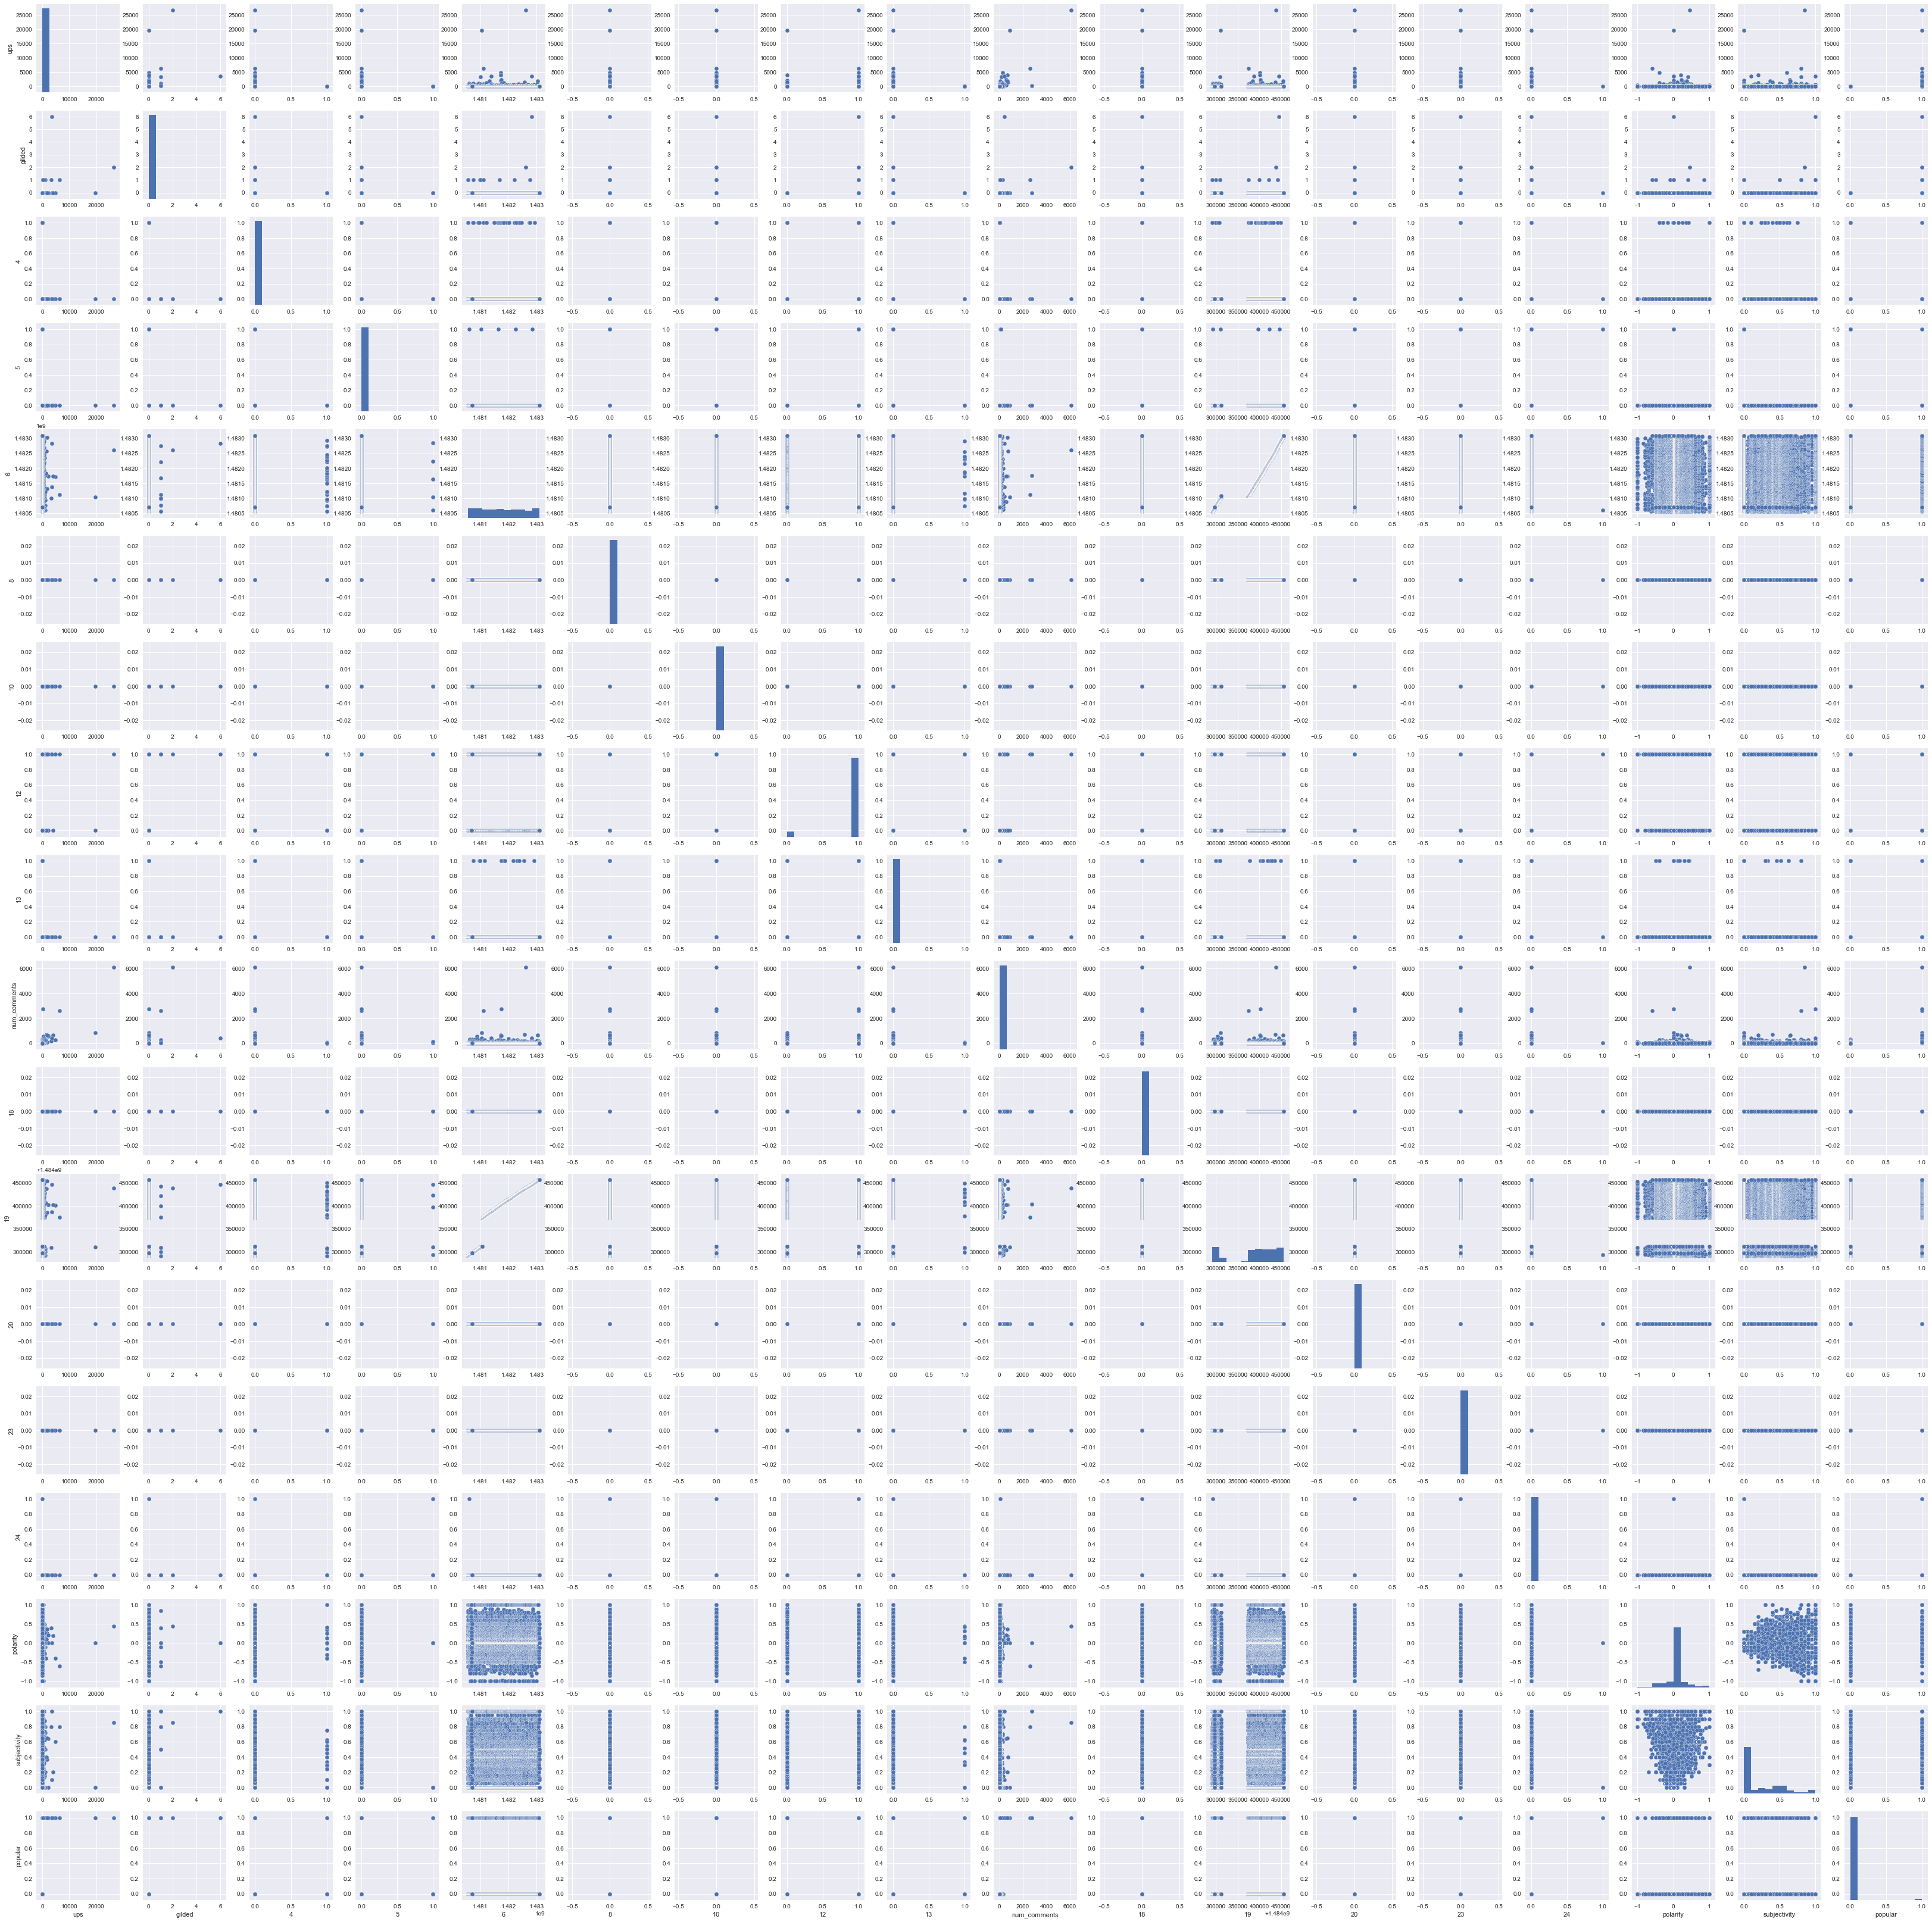

In [61]:
#Pairplot because everyone needs art.  Also I want to see if there's any other correlations on a holistic level.
sns.pairplot(polarity)

In [132]:
#What features are the most closely correlated to popular now, because pairplot gave us many, many, many features.
df_train=polarity.corr()
print (df_train['ups'].sort_values(ascending=False)[:7], '\n')

ups             1.000000
num_comments    0.788890
gilded          0.351811
target          0.167242
subjectivity    0.020445
polarity        0.010033
24              0.001415
Name: ups, dtype: float64 



## Scatter Plots

There's just so many features, but let's have a visual of the above code,

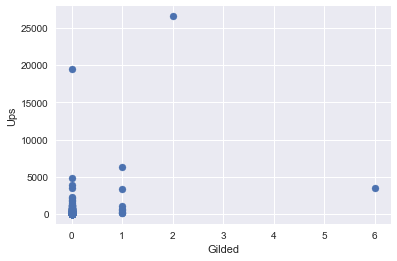

In [133]:
plt.scatter(polarity["gilded"], polarity["ups"])
plt.ylabel("Ups")
plt.xlabel ("Gilded")
plt.show()


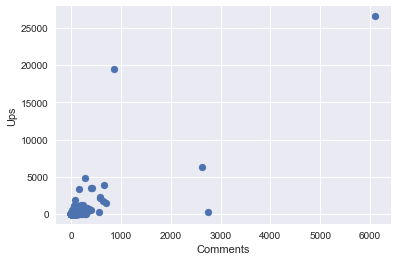

In [135]:
plt.scatter(polarity["num_comments"], polarity["ups"])
plt.ylabel("Ups")
plt.xlabel ("Comments")
plt.show()


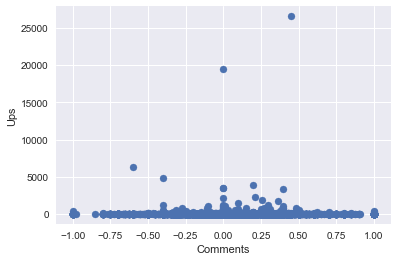

In [136]:
plt.scatter(polarity["polarity"], polarity["ups"])
plt.ylabel("Ups")
plt.xlabel ("Comments")
plt.show()
plt.savefig("polarity & ups scatterplot")

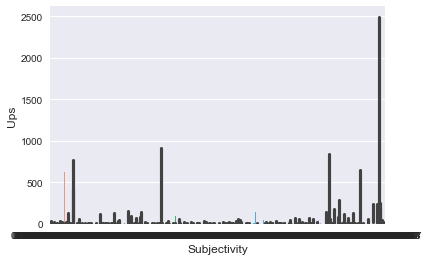

In [137]:
sns.barplot(x='subjectivity', y='ups', data=polarity)
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Ups', fontsize=12)
plt.savefig('subjectivity and Ups')

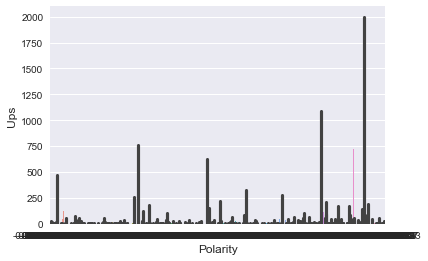

In [138]:
sns.barplot(x='polarity', y='ups', data=polarity)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Ups', fontsize=12)
plt.savefig('polarity and uppers')


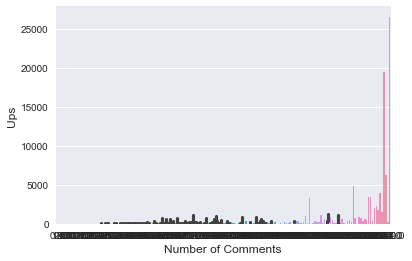

In [139]:
sns.barplot(x='num_comments', y='ups', data=polarity)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Ups', fontsize=12)
plt.savefig('number of comments and uppers')

Text(0,0.5,'Polarity')

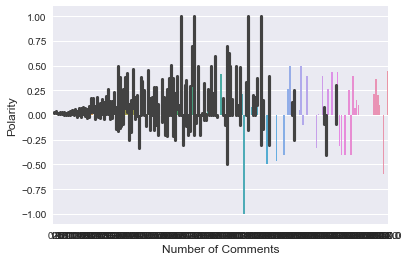

In [140]:
sns.barplot(x='num_comments', y='polarity', data=polarity)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Polarity', fontsize=12)

Text(0,0.5,'Subjectivity')

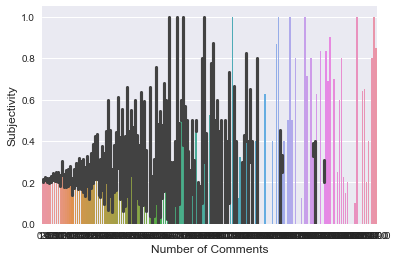

In [141]:
sns.barplot(x='num_comments', y='subjectivity', data=polarity)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Subjectivity', fontsize=12)

# Feature Selection
I've looked at a chunk of art (graphs), and I kind of know what features to wrap into my X axis.  I'm picking gilded (which are awards Reddit users can bestow upon posters), and my subjectivity (bias) and polarity (no bias) numbers.



In [142]:
#Take those features . . . 
#features=["num_comments", "gilded", "subjectivity", "polarity"] Opted not to use num_comments, 
#because the more popular a post the more comments it gets.  I felt that was too biased for my metrics.
features=["gilded", "subjectivity", "polarity"]

In [143]:
#. . . and make them my X.
X=pd.DataFrame(polarity, columns=features)

In [144]:
polarity.columns

Index([         'ups',        'title',              2,       'gilded',
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
       'num_comments',             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,             27,
                   28,     'polarity', 'subjectivity',       'target'],
      dtype='object')

In [145]:
#Establish my y.
y=polarity['target']

In [146]:
y.shape

(22989,)

In [147]:
X.shape

(22989, 3)

In [148]:
#Train, test and split my X and my y.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.60, random_state=1975)

#Check the shapes.
print(X_train.shape,
     X_test.shape,
     y_train.shape,
     y_test.shape)



(9195, 3) (13794, 3) (9195,) (13794,)


# Let the modeling begin

In [150]:
#KNN

knn = KNeighborsClassifier(n_neighbors=5, p=1)
knn.fit(X_train, y_train)
knn_train_score=knn.score(X_train, y_train)
knn_test_score=knn.score(X_test, y_test)
print("This is my train score:",knn_train_score)
print("This is my test score:", knn_test_score)

This is my train score: 0.470799347471
This is my test score: 0.442293750906


In [151]:
#ADA

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50, 75, 100],
    'base_estimator__max_depth': range(2,5),
    'base_estimator__max_features': ['auto', 'log2', None]
}
ada_model = GridSearchCV(ada, param_grid=ada_params)
ada_model.fit(X_train, y_train)
print('best score', ada_model.best_score_)
print('best params', ada_model.best_params_)
print('test score', ada_model.score(X_test, y_test))

best score 0.64284937466
best params {'base_estimator__max_depth': 2, 'base_estimator__max_features': 'log2', 'n_estimators': 50}
test score 0.650137741047


In [154]:
#GBC

gc = GradientBoostingClassifier()
gc_params = {
    "n_estimators": [75, 100, 125],
    "max_depth" : range (2,5),
    "max_features" : ["auto", "log2", None]
    }
gc_model = GridSearchCV(gc, param_grid=gc_params)
gc_model.fit(X_train, y_train)
print('best score', gc_model.best_score_)
print('best params', gc_model.best_params_)
print('test score', gc_model.score(X_test, y_test)) 

best score 0.664926590538
best params {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 75}
test score 0.666304190228


#  Conclusion

Not even a spoonful of Sriracha can ease the slow, fitful burning pain that this dataset has given to me.  

From originally getting models that only gave me negative results (until I switched up from regression to classification).  To getting models that gave me over 98% success (dubious.  One cannot live with too much despair or too much joy) until I checked my baseline accuracy and used a matrix that showed me my false positives were very high . . . until I found that sweet spot where I was able to get models that at least gave me results neither too high nor too low, this has been a journey of twists, turns and burns.

Essentially, I'm most proud of being able to take the title of a post and break it up into subjectivity and polarity metrics.  I'm frustrated I couldn't find better correlations towards up votes, though.

At the end, and after multiple versions of this notebook, I am pleased to put this past me, and to be able to use this notebook as part of my pythonic culinary cookbook.

